In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist # calculate distance matrix
from scipy.linalg import lu # calculate LU decomposition
from scipy.optimize import minimize # minimization of scalar function
from itertools import combinations

In [3]:
import pickle

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/RA-pf.Cao /Regression

/content/drive/MyDrive/Grads/RA-pf.Cao /Regression


In [6]:
with open('./distance.pickle', 'rb') as file:
    d_plot = pickle.load(file)

with open('./calculated_covariance.pickle', 'rb') as file:
    cov_plot = pickle.load(file)

# 3. Regression
* Regression methods tryout:
    * OLS Regrssion
    * Nonlinear Least Squares Regression
    * Gaussian Process Regression (Kriging)
    * Bayesian Inference
    * Kernel Ridge Regression

## 3-3. Gaussian Process Regression (GPR)
1. Define a covariance(kernel) function
2. Calculate the covariance matrix
3. Obtain the posterior distribution $P(\theta|D)$ of the target based on the training data & covariance matrix

In [7]:
# !pip install gpytorch

In [8]:
import torch
import gpytorch

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# set up training data
X = torch.tensor(np.array(d_plot), dtype=torch.float32)
y = torch.tensor(np.array(cov_plot), dtype=torch.float32)

# randomly split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.02, random_state=42)

In [11]:
print("Number of training data points:", X_train.shape[0])

Number of training data points: 19980


In [12]:
# use the simplest form of GP model, Exact inference
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, X_train, y_train, likelihood):
        super(GPModel, self).__init__(X_train, y_train, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(X_train, y_train, likelihood)

Like most PyTorch modules, the ExactGP has a .train() and .eval() mode.
* .train() mode is for optimizing model hyperameters.
* .eval() mode is for computing predictions through the model posterior.

### Training the model

In [13]:
# # train mode - find optimal model hyperparameters
# model.train()
# likelihood.train()

In [14]:
# # use the adam optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# # iteration
# training_iter = 20

# # "Loss" for GPs - the marginal log likelihood
# mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# for i in range(training_iter):
#     # Zero gradients from previous iteration
#     optimizer.zero_grad()
#     # Output from model
#     output = model(X_train)
#     # Calc loss and backprop gradients
#     loss = -mll(output, y_train)
#     loss.backward()

#     if loss.item() > 0:
#       print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#           i + 1, training_iter, loss.item(),
#           model.covar_module.base_kernel.lengthscale.item(),
#           model.likelihood.noise.item()
#       ))
#       optimizer.step()
#     else:
#       break

In [15]:
# torch.save(model.state_dict(), "./trained_gp")

In [16]:
model = GPModel(X_train, y_train, likelihood)
model.load_state_dict(torch.load("./trained_gp"))

<All keys matched successfully>

### Make predictions with the model

In [17]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [18]:
X_test = torch.linspace(min(d_plot), max(d_plot), 50)

In [19]:
f_preds = model(X_test)
y_preds = likelihood(model(X_test))

f_mean = f_preds.mean
f_var = f_preds.variance
f_covar = f_preds.covariance_matrix
f_samples = f_preds.sample(torch.Size([1000]))

/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/linear_operator/operators/_linear_operator.py:2151: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.. Using symeig method.
  warnings.warn(


### Plot the model fit

In [26]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test))

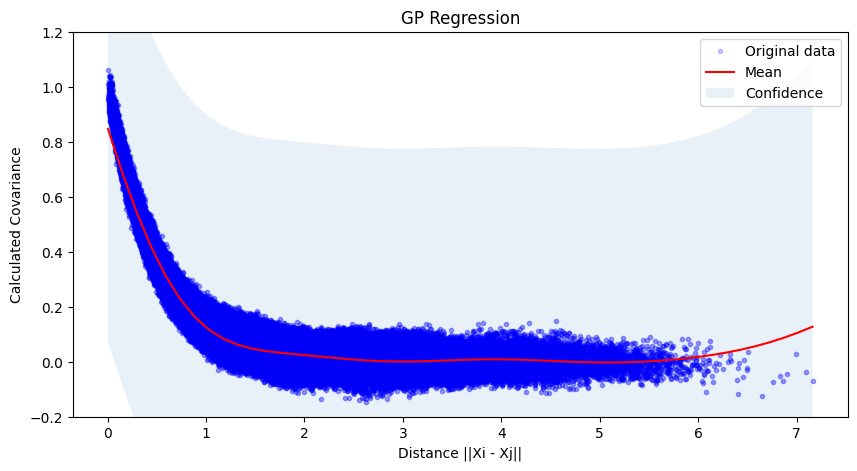

In [46]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as blue dots
    ax.plot(d_plot, cov_plot, '.b', alpha=0.2)
    # Plot predictive means as blue line
    ax.plot(X_test.numpy(), observed_pred.mean.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(X_test.numpy(), lower.numpy(), upper.numpy(), alpha=0.1)

    ax.legend(['Original data', 'Mean', 'Confidence'])
    ax.set_ylim(-0.2, 1.2)
    ax.set_xlabel("Distance ||Xi - Xj||")
    ax.set_ylabel("Calculated Covariance")
    ax.set_title("GP Regression")